In [1]:
from rational.utils.examples.pytorch import prepare_data_pytorch, train_pytorch_model, Flatten
from rational.utils.convert_network import convert_pytorch_model_to_rational

import numpy as np
import torch
from torch.nn import Conv2d, Linear
import torchvision as vision
import matplotlib.pyplot as plt
plt.style.use('bmh')

In [2]:
seed = 4242
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
train_loader, test_loader = prepare_data_pytorch(batch_size=256)

In [4]:
device = 0
epochs = 42

vgg = vision.models.vgg11(pretrained=False).cuda(device)

# change model to fit mnist inputs and outputs   
vgg.features[0] = Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
vgg.avgpool = Flatten()
vgg.classifier = Linear(in_features=512, out_features=10)

In [10]:
rational_model = convert_pytorch_model_to_rational(vgg, rational_cuda=True)

In [6]:
relu_history = train_pytorch_model(vgg, train_loader, test_loader, device=device, epochs=epochs)

[Epoch   1] train_acc: 70.21% - train_loss:  0.960
[Epoch   1] val_acc: 85.92% - val_loss:  0.439
[Epoch   1] Model runtime: 20.912s
[Epoch   2] train_acc: 90.90% - train_loss:  0.286
[Epoch   2] val_acc: 92.29% - val_loss:  0.222
[Epoch   2] Model runtime: 41.633s
[Epoch   3] train_acc: 94.59% - train_loss:  0.170
[Epoch   3] val_acc: 94.56% - val_loss:  0.163
[Epoch   3] Model runtime: 62.352s
[Epoch   4] train_acc: 96.08% - train_loss:  0.121
[Epoch   4] val_acc: 97.98% - val_loss:  0.063
[Epoch   4] Model runtime: 82.516s
[Epoch   5] train_acc: 96.84% - train_loss:  0.101
[Epoch   5] val_acc: 98.37% - val_loss:  0.057
[Epoch   5] Model runtime: 104.119s
[Epoch   6] train_acc: 97.35% - train_loss:  0.084
[Epoch   6] val_acc: 96.61% - val_loss:  0.108
[Epoch   6] Model runtime: 123.924s
[Epoch   7] train_acc: 97.62% - train_loss:  0.076
[Epoch   7] val_acc: 97.77% - val_loss:  0.070
[Epoch   7] Model runtime: 144.056s
[Epoch   8] train_acc: 97.94% - train_loss:  0.068
[Epoch   8] val

In [11]:
rational_history = train_pytorch_model(rational_model, train_loader, test_loader, device=device, epochs=epochs)

[Epoch   1] train_acc: 99.51% - train_loss:  0.015
[Epoch   1] val_acc: 99.23% - val_loss:  0.022
[Epoch   1] Model runtime: 15.146s
[Epoch   2] train_acc: 99.55% - train_loss:  0.014
[Epoch   2] val_acc: 99.11% - val_loss:  0.026
[Epoch   2] Model runtime: 30.098s
[Epoch   3] train_acc: 99.55% - train_loss:  0.014
[Epoch   3] val_acc: 99.30% - val_loss:  0.021
[Epoch   3] Model runtime: 45.022s
[Epoch   4] train_acc: 99.56% - train_loss:  0.014
[Epoch   4] val_acc: 99.30% - val_loss:  0.020
[Epoch   4] Model runtime: 59.430s
[Epoch   5] train_acc: 99.57% - train_loss:  0.013
[Epoch   5] val_acc: 99.26% - val_loss:  0.025
[Epoch   5] Model runtime: 74.503s
[Epoch   6] train_acc: 99.59% - train_loss:  0.013
[Epoch   6] val_acc: 99.26% - val_loss:  0.019
[Epoch   6] Model runtime: 89.167s
[Epoch   7] train_acc: 99.57% - train_loss:  0.012
[Epoch   7] val_acc: 99.23% - val_loss:  0.024
[Epoch   7] Model runtime: 103.890s
[Epoch   8] train_acc: 99.58% - train_loss:  0.013
[Epoch   8] val_a

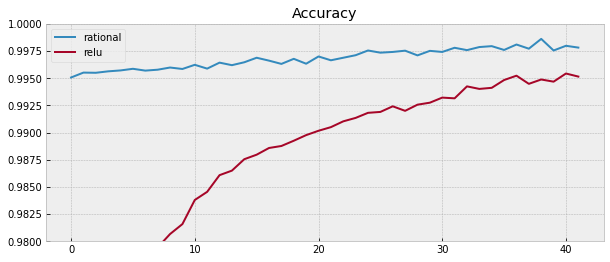

In [12]:
plt.figure(figsize=(10, 4))
plt.plot(range(epochs), rational_history['accuracy'], label='rational')
plt.plot(range(epochs), relu_history['accuracy'], label='relu')
plt.title('Accuracy')
plt.ylim((0.98, 1))
plt.legend()
plt.show()

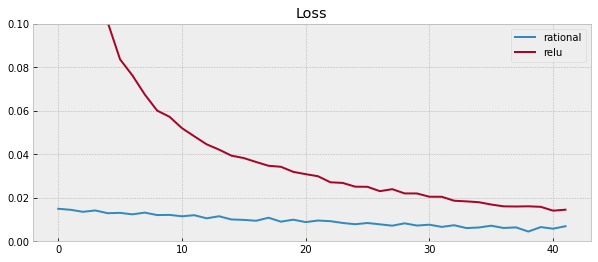

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(range(epochs), rational_history['loss'], label='rational')
plt.plot(range(epochs), relu_history['loss'], label='relu')
plt.title('Loss')
plt.ylim((0, 0.1))
plt.legend()
plt.show()

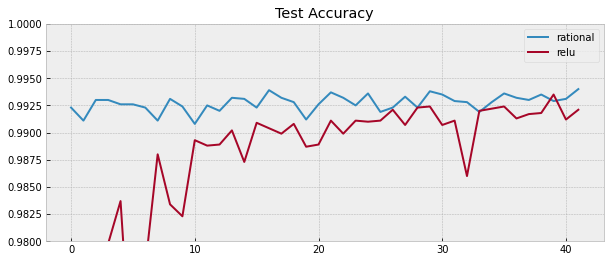

In [14]:
plt.figure(figsize=(10, 4))
plt.plot(range(epochs), rational_history['val_accuracy'], label='rational')
plt.plot(range(epochs), relu_history['val_accuracy'], label='relu')
plt.title('Test Accuracy')
plt.ylim((0.98, 1))
plt.legend()
plt.show()

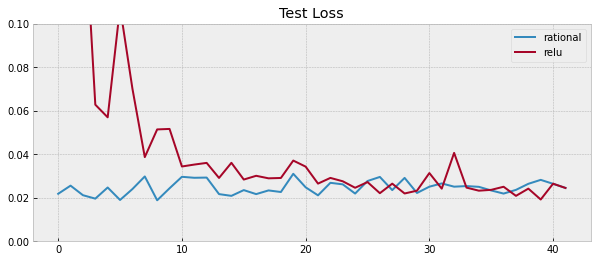

In [15]:
plt.figure(figsize=(10, 4))
plt.plot(range(epochs), rational_history['val_loss'], label='rational')
plt.plot(range(epochs), relu_history['val_loss'], label='relu')
plt.title('Test Loss')
plt.ylim((0, 0.1))
plt.legend()
plt.show()